In [122]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from fbprophet import Prophet
import pmdarima as pm


Pulling in Data from KU_Pandas_for_database for a trial run of the Machine Learning Model

In [64]:
import yfinance as yf
df_apple = yf.download('AAPL', start='2019-01-01', end='2022-01-01', progress=False)

df_apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.221367,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.414234,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.883358,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.803490,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.486012,164101200


In [65]:
df_sp = yf.download('^GSPC', start='2019-01-01', end='2022-01-01', progress=False)

Plotting Closing Price to visualize 

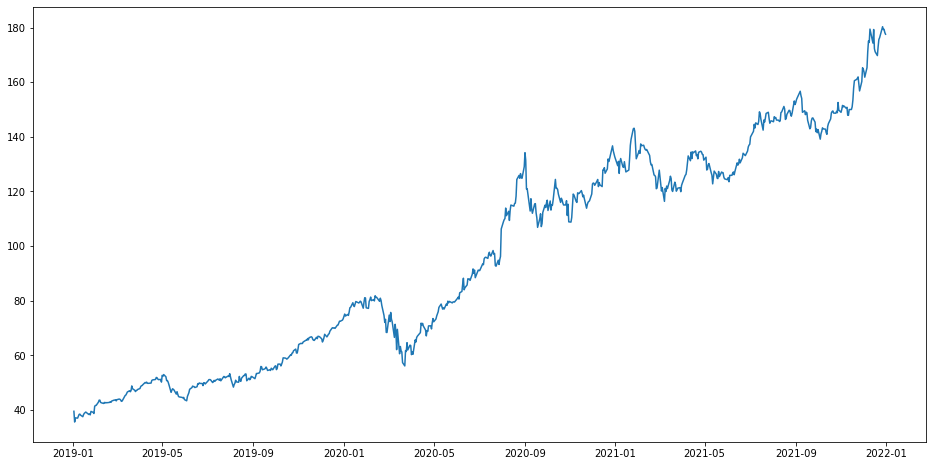

In [66]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df_apple['Close'], label='Close Price History')

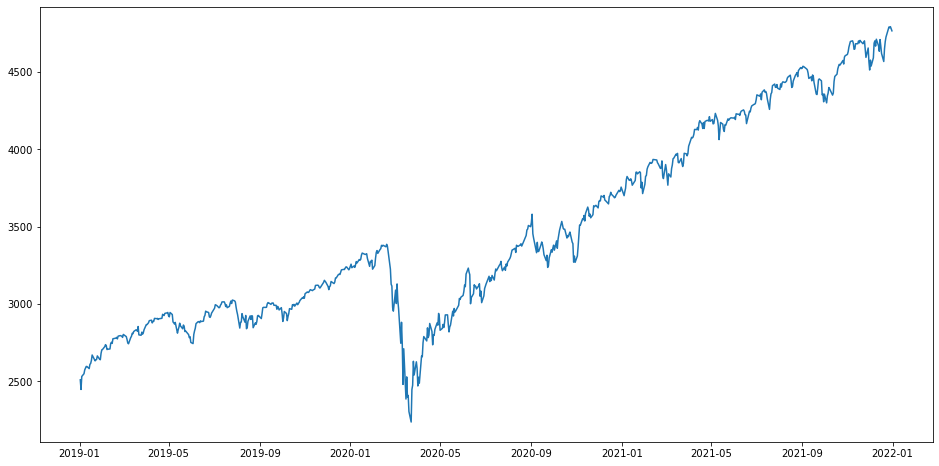

In [69]:
plt.figure(figsize=(16,8))
plt.plot(df_sp['Close'], label='Close Price History')

Looking at the Distribution of the Dataset

<AxesSubplot:ylabel='Density'>

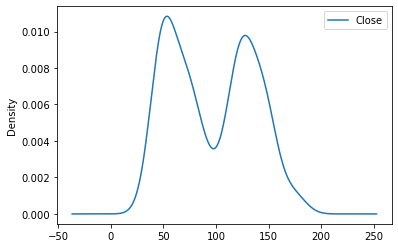

In [84]:
df_apple_close = df_apple[['Close']]
df_apple_close.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

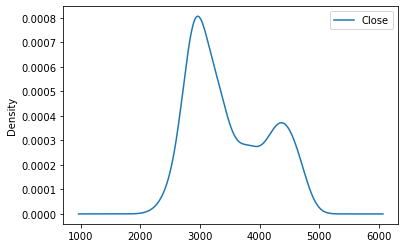

In [83]:
df_sp_close = df_sp[['Close']]
df_sp_close.plot(kind='kde')

Splitting Data into Train and Test DataSet into 80% Training Data and 20% Testing Data

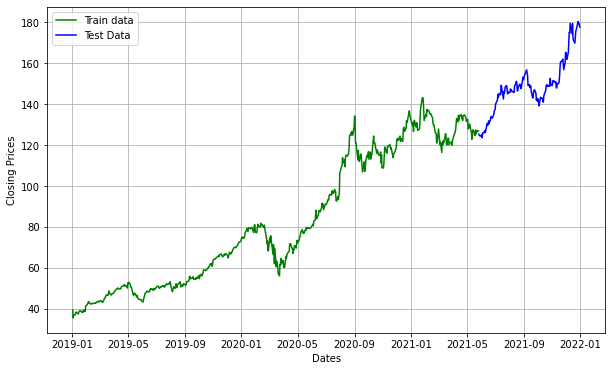

In [139]:
apple_train_data= df_apple_close.iloc[:int(df_apple_close.shape[0]*0.8)]
apple_test_data = df_apple_close.iloc[int(df_apple_close.shape[0]*0.80):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(apple_train_data, 'Green', label='Train data')
plt.plot(apple_test_data, 'blue',  label='Test Data')
plt.legend()

This Machine Learning Model will run a linear regression, ARIMA model, and a Facebook Prophet model
- limitations of these models will be they do not take into account current world situations (like COVID impacts on economy)

Linear Regression Model

In [89]:
df_linear_apple = pd.merge(df_apple_close, df_sp_close, on='Date')
df_linear_apple = df_linear_apple.rename(columns={'Close_x': 'Apple Close', 'Close_y':'S&P Close'})

In [96]:
# for linear regression model we need an x_train value, and a y_train value
X_train, X_test, y_train, y_test = train_test_split(df_linear_apple[['Apple Close']], df_linear_apple[['S&P Close']], test_size=.2)

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [98]:
y_pred = linear_regression_model.predict(X_test)

In [111]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [114]:
print('Mean Absolute Error:', mae)
print('Coefficient of Determination:', r2)
print('Mean Squared Error:', mse)

Mean Absolute Error: 192.11079106982197
Coefficient of Determination: 0.8939045221457279
Mean Squared Error: 47831.49727104222


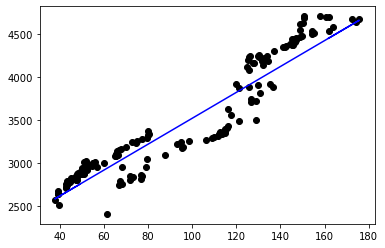

In [116]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue')
plt.show()

Arima Model

In [124]:
# ARIMA Model
arima_model = pm.auto_arima(apple_train_data, d=1, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=6, max_order=None , trace=True)

arima_model.fit(apple_train_data)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2543.432, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2547.861, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2538.124, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2538.851, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2549.183, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2539.699, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2539.590, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2541.579, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2540.484, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.825 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [142]:
arima_y_pred = apple_test_data.copy()

# Forecasting the Data
prediction_arima = arima_model.predict(len(apple_test_data))
arima_y_pred["ARIMA Model Prediction"]=prediction_arima

In [144]:
r2_arima = r2_score(y_pred["Close"], y_pred["ARIMA Model Prediction"])
mae_arima = mean_absolute_error(y_pred["Close"], y_pred["ARIMA Model Prediction"])
mse_arima = mean_squared_error(y_pred['Close'], y_pred["ARIMA Model Prediction"])

print('Mean Absolute Error for ARIMA Model:', mae_arima)
print('Coefficient of Determination for ARIMA Model:', r2_arima)
print('Mean Squared Error for ARIMA Model:', mse_arima)

Mean Absolute Error for ARIMA Model: 11.013600973678676
Coefficient of Determination for ARIMA Model: -0.06766808591836293
Mean Squared Error for ARIMA Model: 183.63384977361667


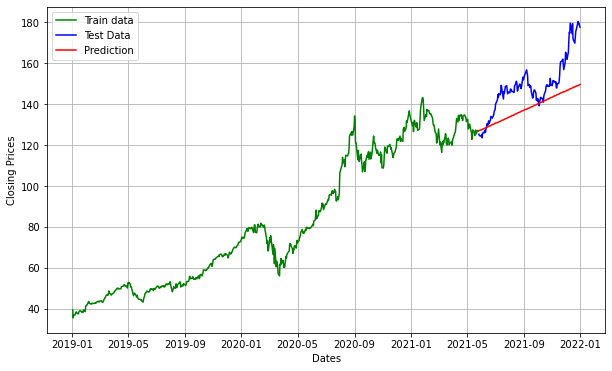

In [146]:
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(apple_train_data, 'Green', label='Train data')
plt.plot(apple_test_data, 'blue',  label='Test Data')
plt.plot(arima_y_pred["ARIMA Model Prediction"], 'Red', label='Prediction')
plt.legend()


Facebook Prophet Model with Plot of Actual vs Predictions

In [173]:
# Facebook Prophet Model
prophet_data = df_apple_close.copy()
prophet_data = prophet_data.reset_index()

#preparing data
prophet_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
prophet_train = prophet_data[:int(prophet_data.shape[0]*0.80)]
prophet_test = prophet_data[int(prophet_data.shape[0]*0.80):]

#fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

#predictions
close_prices = prophet_model.make_future_dataframe(periods=len(prophet_test))
forecast = prophet_model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.72316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.91     0.0285079       278.279           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       1845.91   0.000169997       293.446   3.862e-07       0.001      235  LS failed, Hessian reset 
     199       1852.52    0.00460057        278.09           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1864.87   0.000442165       117.905           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1866.73   0.000108217       215.292   5.706e-07       0.001      449  LS failed, Hessian reset 
     397       1869.21   0.000104583       147.996    9.23e-07       0.001      597  LS failed, Hessian rese

In [174]:
forecast = forecast.set_index('ds')
forecast = forecast.rename(columns={'yhat':'Prediction'})

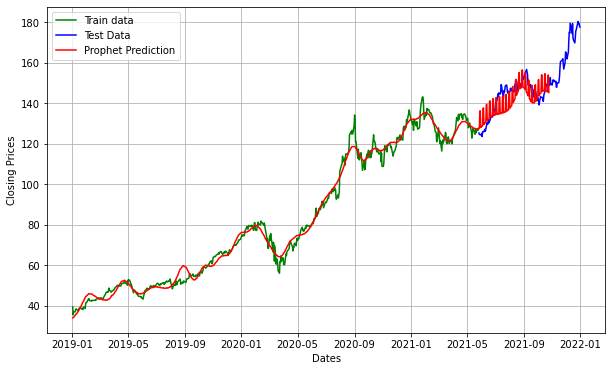

In [175]:
# Facebook Prophet Models
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(apple_train_data, 'Green', label='Train data')
plt.plot(apple_test_data, 'blue',  label='Test Data')
plt.plot(forecast['Prediction'], 'Red', label='Prophet Prediction')
plt.legend()



In [177]:
# Get Statistics for Prophet Predictions